In [1]:
#import packages
import pandas as pd
import re 
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet
import seaborn as sb
from textblob import TextBlob

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
#read in dataset
file_location='nps_score_feedback_survey.csv'
input_df = pd.read_csv(file_location)
input_df.dropna(inplace=True)
input_df.head(5)

,nps_score,Comments
1,10,Easy to use and I like that we are finally at ...
2,10,Easy to use. Happy that we are finally at this...
3,7,Harder to navigate to find the equipment unlik...
4,10,The new website and app has made it easier for...
5,7,Because the site makes it appear that they can...


In [3]:
#clean data, remove stop words,etc
pattern = r"\&\#[0-9]+\;"
input_df['clean_comment']=input_df['Comments'].str.replace(pat=pattern, repl="",regex=True)

In [4]:
input_df.head(6)

,nps_score,Comments,clean_comment
1,10,Easy to use and I like that we are finally at ...,Easy to use and I like that we are finally at ...
2,10,Easy to use. Happy that we are finally at this...,Easy to use. Happy that we are finally at this...
3,7,Harder to navigate to find the equipment unlik...,Harder to navigate to find the equipment unlik...
4,10,The new website and app has made it easier for...,The new website and app has made it easier for...
5,7,Because the site makes it appear that they can...,Because the site makes it appear that they can...
8,10,Anything to speed up the pace and make things ...,Anything to speed up the pace and make things ...


In [5]:
type(input_df['clean_comment'])

pandas.core.series.Series

In [6]:
resources = ["wordnet", "stopwords", "punkt", \
             "averaged_perceptron_tagger", "maxent_treebank_pos_tagger"]

for resource in resources:
    try:
        nltk.data.find("tokenizers/" + resource)
    except LookupError:
        nltk.download(resource)

#create Lemmatizer object
lemma = WordNetLemmatizer()

def lemmatize_word(tagged_token):
    """ Returns lemmatized word given its tag"""
    root = []
    for token in tagged_token:
        tag = token[1][0]
        word = token[0]
        if tag.startswith('J'):
            root.append(lemma.lemmatize(word, wordnet.ADJ))
        elif tag.startswith('V'):
            root.append(lemma.lemmatize(word, wordnet.VERB))
        elif tag.startswith('N'):
            root.append(lemma.lemmatize(word, wordnet.NOUN))
        elif tag.startswith('R'):
            root.append(lemma.lemmatize(word, wordnet.ADV))
        else:          
            root.append(word)
    return root

def lemmatize_doc(document):
    """ Tags words then returns sentence with lemmatized words"""
    lemmatized_list = []
    tokenized_sent = sent_tokenize(document)
    for sentence in tokenized_sent:
        no_punctuation = re.sub(r"[`'\",.!?()]", " ", sentence)
        tokenized_word = word_tokenize(no_punctuation)
        tagged_token = pos_tag(tokenized_word)
        lemmatized = lemmatize_word(tagged_token)
        lemmatized_list.extend(lemmatized)
    return " ".join(lemmatized_list)

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!


In [7]:
input_df["clean_comment"] = input_df["clean_comment"].apply(lambda row: lemmatize_doc(row))
pattern = r"[^\w\s]"
input_df["clean_comment"] = input_df["clean_comment"].str.replace(pat=pattern, repl=" ", regex=True)
input_df["clean_comment"] = input_df["clean_comment"].str.lower()

In [8]:
def polarity_check(input_str):
    sid = SIA()
    return sid.polarity_scores(input_str)
def sentiment_check(input_str):
    return TextBlob(input_str).sentiment  

input_df['polarity_score'] = input_df["clean_comment"].apply(polarity_check)
df2 = pd.json_normalize(input_df['polarity_score'])
input_df=input_df.join(df2)
input_df['word_count'] = input_df['clean_comment'].str.split().str.len()
input_df['sentiment_raw'] = input_df['clean_comment'].apply(sentiment_check)
input_df['sentiment_raw'].tolist()
input_df[['polarity', 'subjectivity']] = pd.DataFrame(input_df['sentiment_raw'].tolist(), index=input_df.index)

In [9]:
input_df.head(10)

,nps_score,Comments,clean_comment,polarity_score,neg,neu,pos,compound,word_count,sentiment_raw,polarity,subjectivity
1,10,Easy to use and I like that we are finally at ...,easy to use and i like that we be finally at t...,"{'neg': 0.0, 'neu': 0.69, 'pos': 0.31, 'compou...",0.000,0.625,0.375,0.7650,16,"(0.21666666666666667, 0.9166666666666667)",0.216667,0.916667
2,10,Easy to use. Happy that we are finally at this...,easy to use happy that we be finally at this l...,"{'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'comp...",0.000,1.000,0.000,0.0000,14,"(0.41111111111111115, 0.9444444444444445)",0.411111,0.944444
3,7,Harder to navigate to find the equipment unlik...,harder to navigate to find the equipment unlik...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.805,0.195,0.4404,19,"(0.0, 0.1)",0.000000,0.100000
4,10,The new website and app has made it easier for...,the new website and app have make it easy for ...,"{'neg': 0.0, 'neu': 0.805, 'pos': 0.195, 'comp...",0.055,0.905,0.041,-0.2263,13,"(0.28484848484848485, 0.6439393939393939)",0.284848,0.643939
5,7,Because the site makes it appear that they can...,because the site make it appear that they can ...,"{'neg': 0.055, 'neu': 0.905, 'pos': 0.041, 'co...",0.000,1.000,0.000,0.0000,62,"(-0.07777777777777775, 0.47222222222222215)",-0.077778,0.472222
8,10,Anything to speed up the pace and make things ...,anything to speed up the pace and make thing r...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.117,0.810,0.072,-0.4767,11,"(0.0, 0.0)",0.000000,0.000000
9,1,It is not user friendly. It does not work and ...,it be not user friendly it do not work and the...,"{'neg': 0.182, 'neu': 0.818, 'pos': 0.0, 'comp...",0.238,0.762,0.000,-0.3612,22,"(0.08749999999999998, 0.5666666666666667)",0.087500,0.566667
10,8,I find the PC search more difficult and I can'...,i find the pc search more difficult and i can ...,"{'neg': 0.117, 'neu': 0.883, 'pos': 0.0, 'comp...",0.197,0.803,0.000,-0.4019,25,"(0.16666666666666666, 0.7083333333333334)",0.166667,0.708333
11,5,I recommend it based on the ease of which you ...,i recommend it base on the ease of which you c...,"{'neg': 0.117, 'neu': 0.81, 'pos': 0.072, 'com...",0.000,1.000,0.000,0.0000,64,"(-0.125, 0.738095238095238)",-0.125000,0.738095
13,5,have gotten feedback that it is difficult to use,have get feedback that it be difficult to use,"{'neg': 0.238, 'neu': 0.762, 'pos': 0.0, 'comp...",0.000,1.000,0.000,0.0000,9,"(-0.5, 1.0)",-0.500000,1.000000


array([[<AxesSubplot:title={'center':'nps_score'}>,
        <AxesSubplot:title={'center':'neg'}>,
        <AxesSubplot:title={'center':'neu'}>],
       [<AxesSubplot:title={'center':'pos'}>,
        <AxesSubplot:title={'center':'compound'}>,
        <AxesSubplot:title={'center':'word_count'}>],
       [<AxesSubplot:title={'center':'polarity'}>,
        <AxesSubplot:title={'center':'subjectivity'}>, <AxesSubplot:>]],
      dtype=object)

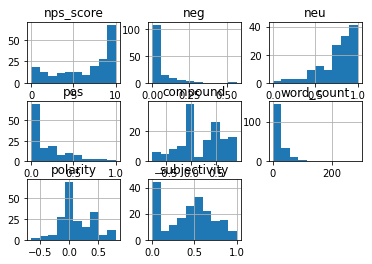

In [10]:
input_df.hist()

In [11]:
input_df.describe()

,nps_score,neg,neu,pos,compound,word_count,polarity,subjectivity
count,196.000000,141.000000,141.000000,141.000000,141.000000,196.000000,196.000000,196.000000
mean,6.301020,0.040454,0.763135,0.196447,0.199219,24.505102,0.134341,0.421051
std,3.445726,0.080307,0.222300,0.234528,0.413465,33.812530,0.288151,0.290251
min,0.000000,0.000000,0.000000,0.000000,-0.786100,1.000000,-0.650000,0.000000
25%,3.750000,0.000000,0.633000,0.000000,0.000000,7.000000,0.000000,0.156250
50%,7.000000,0.000000,0.808000,0.100000,0.242700,14.000000,0.000000,0.471825
75%,10.000000,0.055000,0.942000,0.303000,0.493900,30.500000,0.375000,0.625000
max,10.000000,0.568000,1.000000,1.000000,0.908100,287.000000,0.800000,1.000000


In [13]:
# TODO: max of worst comment and good comment - sort by word count as well - newsletter
feature_column = ['word_count','neg','neu','pos','polarity','subjectivity']
print(input_df[feature_column].corr())

              word_count       neg       neu       pos  polarity  subjectivity
word_count      1.000000 -0.034908  0.052485 -0.037782 -0.174754      0.089892
neg            -0.034908  1.000000 -0.023868 -0.319720 -0.149741     -0.148907
neu             0.052485 -0.023868  1.000000 -0.939611  0.037616      0.106370
pos            -0.037782 -0.319720 -0.939611  1.000000  0.015694     -0.049737
polarity       -0.174754 -0.149741  0.037616  0.015694  1.000000      0.417232
subjectivity    0.089892 -0.148907  0.106370 -0.049737  0.417232      1.000000


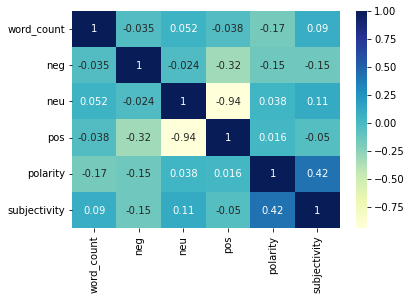

In [14]:
dataplot = sb.heatmap(input_df[feature_column].corr(), cmap="YlGnBu", annot=True)
# the more word count there is - the less likely it would be positive - got more things to say? its most likely bad

In [15]:
polarity_check('this is AWFUL, terrible bad, what are you doing with yourself. Please this website is a disaster')

{'neg': 0.52, 'neu': 0.397, 'pos': 0.083, 'compound': -0.9206}

In [39]:
TextBlob('this is not bad').sentiment

Sentiment(polarity=0.3499999999999999, subjectivity=0.6666666666666666)

In [41]:
input_df.shape

(196, 12)

In [17]:
input_df.nlargest(n=5, columns=['polarity','subjectivity']) # super biased subject 

,nps_score,Comments,clean_comment,polarity_score,neg,neu,pos,compound,word_count,sentiment_raw,polarity,subjectivity
64,10,great app,great app,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...",0.000,0.742,0.258,0.8687,2,"(0.8, 0.75)",0.8,0.75
86,10,it is great for the customers to use,it be great for the customer to use,"{'neg': 0.0, 'neu': 0.631, 'pos': 0.369, 'comp...",0.000,0.857,0.143,0.2500,8,"(0.8, 0.75)",0.8,0.75
110,7,Great for account customers to place orders an...,great for account customer to place order and ...,"{'neg': 0.096, 'neu': 0.818, 'pos': 0.086, 'co...",0.000,0.465,0.535,0.7845,44,"(0.8, 0.75)",0.8,0.75
141,10,works great,work great,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...",0.000,0.541,0.459,0.7783,2,"(0.8, 0.75)",0.8,0.75
164,10,GREAT TOOL,great tool,"{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...",0.105,0.824,0.071,-0.1280,2,"(0.8, 0.75)",0.8,0.75


In [42]:
input_df[input_df['nps_score'] < 6 ].nsmallest(n=20, columns=['polarity','subjectivity'])

,nps_score,Comments,clean_comment,polarity_score,neg,neu,pos,compound,word_count,sentiment_raw,polarity,subjectivity
116,0,The program is very flawed.,the program be very flawed,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.508,0.492,0.4404,5,"(-0.65, 0.65)",-0.650000,0.650000
74,3,Customers can overbook on any item anywhere an...,customers can overbook on any item anywhere an...,"{'neg': 0.106, 'neu': 0.894, 'pos': 0.0, 'comp...",0.185,0.815,0.000,-0.6997,32,"(-0.625, 1.0)",-0.625000,1.000000
13,5,have gotten feedback that it is difficult to use,have get feedback that it be difficult to use,"{'neg': 0.238, 'neu': 0.762, 'pos': 0.0, 'comp...",0.000,1.000,0.000,0.0000,9,"(-0.5, 1.0)",-0.500000,1.000000
108,5,Credit Card process and system errors have mad...,credit card process and system error have make...,"{'neg': 0.25, 'neu': 0.625, 'pos': 0.125, 'com...",0.060,0.857,0.083,0.1779,16,"(-0.5, 1.0)",-0.500000,1.000000
68,0,I have to log in twice to even get into the we...,i have to log in twice to even get into the we...,"{'neg': 0.056, 'neu': 0.855, 'pos': 0.089, 'co...",0.000,0.857,0.143,0.8658,54,"(-0.4, 0.44999999999999996)",-0.400000,0.450000
134,3,very slow navigating from screen to screen ver...,very slow navigating from screen to screen ver...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.631,0.369,0.6249,17,"(-0.39000000000000007, 0.52)",-0.390000,0.520000
177,1,The site is misleading. Customers are disappoi...,the site be mislead customers be disappointed ...,"{'neg': 0.094, 'neu': 0.86, 'pos': 0.045, 'com...",0.000,0.868,0.132,0.4767,77,"(-0.3375, 0.6625)",-0.337500,0.662500
118,3,Since the change I have had to event several t...,since the change i have have to event several ...,"{'neg': 0.055, 'neu': 0.945, 'pos': 0.0, 'comp...",0.000,0.571,0.429,0.4588,43,"(-0.3333333333333333, 0.5)",-0.333333,0.500000
23,1,The system is always slow can't log in can't m...,the system be always slow can t log in can t m...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.779,0.221,0.6249,17,"(-0.30000000000000004, 0.39999999999999997)",-0.300000,0.400000
173,4,extremely slow -,extremely slow,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,2,"(-0.30000000000000004, 0.39999999999999997)",-0.300000,0.400000


## Objective 1 - sentiment analysis based on subjectivity and polarity

In [33]:
=' '.join(input_df[input_df['nps_score'] < 6 ].nsmallest(n=15, columns=['polarity','subjectivity'])['Comments'])

"The program is very flawed.  Customers can overbook on any item anywhere and then get mad at the store when we don't have it or can't deliver in 1hr to a site 2 hrs away. have gotten feedback that it is difficult to use  Credit Card process and system errors have made it difficult for our customers to make payments. I have to log in twice to even get into the website. It is extremely slow. There is nothing but problems, no receipts, cannot log in. Customers complaining it is not working. Unable to process payments, or pull invoices. etc. Have to re log in over and over and over again every day. very slow navigating from screen to screen very slow processing payments while on the phone with customers    The site is misleading. Customers are disappointed when notified that the equipment is unavailable in our state or region. The site allows customers to reserve and issue payment on equipment that is not in the rental fleet. It also allows to select units that are not available or have p

In [34]:
#input_df.to_csv('nps_scored_added.csv')

In [35]:
nps_lower_worst=' '.join(input_df[input_df['nps_score'] < 6 ].nsmallest(n=15, columns=['polarity','subjectivity'])['Comments'])

## Objective 2 - exec summary of selective comments

In [36]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
model = AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-cnn-12-6")
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6")
ARTICLE_TO_SUMMARIZE=nps_lower_worst
inputs = tokenizer([ARTICLE_TO_SUMMARIZE], max_length=2000, return_tensors="pt")
# Generate Summary
summary_ids = model.generate(inputs["input_ids"], num_beams=6, min_length=1, max_length=2000)
tokenizer.batch_decode(summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size


" Customers can overbook on any item anywhere and then get mad at the store when we don't have it or can't deliver in 1hr to a site 2 hrs away . Customers are disappointed when notified that the equipment is unavailable in our state or region . The site allows customers to reserve and issue payment on equipment not in the rental fleet ."